## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)
library(reshape2)
library(tidyverse)
library(data.table)
library(Rtsne)
library(ggrepel)
library(repr)

theme_nogrid = function(...) theme_bw() + theme(axis.line = element_line(colour = "black"),
                            panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(),
                             panel.background = element_blank())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr

## Set paths to reference files

In [2]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','BRCA_Basal','MM','OV')

#ATAC project color scales
path_to_ATAC_colors='../data/Colors_panatac_v2.0.rds'

#Matrix with accessibility averaged per tumor cells from each sample, and per normal cells from tissue
path_to_ATAC_average_matrix='../data/snATAC/Average_accessibility_matrix.DataSlot.20230212.tsv'

#Cell counts per each cell group in matrix with average ATAC accessibility
path_to_ATAC_average_matrix_meta='../data/snATAC/Cell_count_perGroup.forAverageAccessibilityMatrix.20230212.tsv'

#ATAC catalog
path_to_ATAC_catalog='../data/ATAC_catalog.20220114.v2.txt'

#Tissue- and cancer-specific DACRs, Supplementary Table S2a
path_to_ATAC_tiss_can_DACRs='../data/snATAC/Table_S2a_tiss_cancer_DACRs.txt'

## Set color scales

In [3]:
cols=readRDS(path_to_ATAC_colors)
dis_cols_ed <- cols$Cancer

tiss_cols=c("Tumor"="#377EB8","Normal"="#4DAF4A","Met"="#E41A1C")

In [4]:
#Read catalog
cat=read_delim(path_to_ATAC_catalog,delim='\t')
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat$Piece_ID=paste(cat$Disease_Type,cat$Piece_ID,sep='_')
cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')

Rows: 225 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Disease Type, Sample ID, Case ID, Piece_ID, Sample Type, Data Type...
lgl  (2): Include in the downstream analysis, Include in immune

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#Read average accessibility matrix
tab_1=fread(path_to_ATAC_average_matrix)
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab=tab_1

Warning message in fread(path_to_ATAC_average_matrix):
“Detected 245 column names but the data has 246 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [6]:
#Remove cell groups with too few number of cells
meta=read.table(path_to_ATAC_average_matrix_meta,sep='\t',header=T)
meta$Cell_type=gsub(' ','-',meta$Cell_type)
meta_s=meta[meta$Cell_count>=20 ,]
colnames(tab)=gsub('\\.','-',colnames(tab))

In [7]:
#Add row annotation
tab=t(tab)
rownames(tab)=gsub(' ','-',rownames(tab))
tab=tab[rownames(tab) %in% meta_s$Cell_type,]

row_annot=as.data.frame(rownames(tab))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$Cell_type)
row_annot$Disease=gsub('(.*)__(.*)_(.*)','\\2',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$Disease)

row_annot$Piece_ID=gsub('Tumor__','',row_annot$ID)
row_annot$Disease=gsub('(.*)_.*','\\1',row_annot$Disease)

#Annotate BRCA basal samples
row_annot$Disease=ifelse(row_annot$ID %in% 
                         paste('Tumor__BRCA',c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),sep='_'),
                         'BRCA_Basal',row_annot$Disease)

#Remove groups annotated as doublets
row_annot=row_annot[!(row_annot$ID %in% c('CRC__Other_doublets','PDAC_Other_doublets')),]
rownames(row_annot)=row_annot$ID

row_annot=merge(row_annot, cat,all.x=T)
rownames(row_annot)=row_annot$ID

tab=tab[rownames(row_annot),]

In [8]:
#Read tissue- and cancer-specific DACRs
daps=read.table(path_to_ATAC_tiss_can_DACRs, sep='\t', header=T)
daps=daps[daps$p_val_adj<0.05,]
tab_s=tab[,unique(daps$peak)]

In [9]:
#Make correlation matrix based on accessibilities of tissue- and cancer-specific DACRs, using all cell groups
mydata.cor = cor(t(scale(tab_s)), method = c("pearson"))

In [10]:
#Add row annotation
dd1=as.matrix(mydata.cor)
row_annot=as.data.frame(row.names(dd1))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$ID)
row_annot$Disease=gsub('Tumor__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Piece_ID=gsub('Tumor__(.*)_(.*)','\\2',row_annot$ID)

#Extract Piece_ID and Disease info for OV samples with "_" in ids
row_annot$Piece_ID=ifelse(row_annot$ID %in% c('Tumor__OV_VF026V1-S1_1N1','Tumor__OV_VF027V1-S1_1N1','Tumor__OV_VF032V1_S1N1','Tumor__OV_VF035V1_S1N1'), gsub('Tumor__(.*)_(.*)_(.*)','\\2_\\3',row_annot$ID),row_annot$Piece_ID)
row_annot$Disease=ifelse(row_annot$ID %in% c('Tumor__OV_VF026V1-S1_1N1','Tumor__OV_VF027V1-S1_1N1','Tumor__OV_VF032V1_S1N1','Tumor__OV_VF035V1_S1N1'),'OV',row_annot$Disease)

#Extract Disease info for all other samples
row_annot$Disease=ifelse(row_annot$Piece_ID %in% c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),'BRCA_Basal',row_annot$Disease)


#Add annotation for CEAD samples
row_annot$Disease=ifelse(row_annot$Piece_ID %in% c('CE332E1-N1','CE336E1-S1','CE354E1-S1','CE357E1-S1','CE507-C1A2'),'CEAD',row_annot$Disease)

#Identify tumor cell groups
row_annot$Cell_type=ifelse(grepl('Tumor__',row_annot$ID),'Tumor',row_annot$Cell_type)
rownames(row_annot)=row_annot$ID
row_annot$Cell_type=gsub('-',' ',row_annot$Cell_type)

#Annotate normal cell types based on tissue they belong. They will be used as potential CNCs.
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Acinar","Acinar REG+","ADM","Islets","Ductal like1","Ductal like2"),'PDAC',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Ciliated Endometrial epithelial cells","Secretory Endometrial epithelial cells"),'UCEC',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Astrocytes","OPC","Oligodendrocytes"),'GBM',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Basal progenitor","Luminal mature","Luminal progenitor"),'BRCA',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Collecting Duct Intercalated Cells A","Collecting Duct Intercalated Cells B","Collecting Duct Principal Cells","Distal Convoluted Tubule","Loop of Henle","Podocytes","Proximal Tubule"),'ccRCC',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Distal Absorptive","Distal Enterocytes","Distal Mature Enterocytes", "Distal Stem Cells","Distal TA","TA","Goblet"),'CRC',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Keratinocytes","Melanocytes"),'SKCM',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Cell_type %in% c("Normal squamous cells","Normal epithelial cells"),'CESC',row_annot$Disease)
row_annot$Piece_ID=ifelse(row_annot$Cell_type!='Tumor','',row_annot$Piece_ID)


In [11]:
#Extract correlation coefficients between samples from each tumor type and their respective CNCs.
dd1=as.matrix(mydata.cor)

cancers=c('GBM','PDAC','UCEC','BRCA','BRCA_Basal','ccRCC','CRC','OV','HNSCC','CESC','SKCM','CEAD')

all_stat=NULL
for(can in cancers){
print(can)

if(can %in% c('BRCA','BRCA_Basal')){
    row_annot_s=row_annot[row_annot$Disease %in% c('BRCA','BRCA_Basal'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]
}else if (can %in% c('CESC','HNSCC','CEAD')){
    row_annot_s=row_annot[row_annot$Disease %in% c('CESC','HNSCC','CEAD'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}else if (can %in% c('OV','UCEC')){
    row_annot_s=row_annot[row_annot$Disease %in% c('OV','UCEC'),]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor' & row_annot_s$Disease==can,]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}else{
    row_annot_s=row_annot[row_annot$Disease==can,]
    dd1_s=dd1[rownames(row_annot_s),rownames(row_annot_s)]
    row_annot_s1=row_annot_s[row_annot_s$Cell_type=='Tumor',]
    row_annot_s2=row_annot_s[row_annot_s$Cell_type!='Tumor',]

}

dd1_s1=dd1_s[rownames(row_annot_s1),rownames(row_annot_s2)]

cell_types=unique(row_annot_s2$Cell_type)
all_tab_h1=NULL
for (cell_t in cell_types){
    ids=rownames(row_annot_s2[row_annot_s2$Cell_type==cell_t,])
    tab_h=dd1_s1[,ids]
    tab_h1=as.data.frame(reshape2::melt(as.matrix(tab_h)))
    tab_h1$Cell_type=cell_t
    tab_h1$Cancer=can
    all_tab_h1=rbind(all_tab_h1,tab_h1)	
}
all_tab_h1=as.data.frame(all_tab_h1)
all_stat=rbind(all_stat,all_tab_h1)
}

all_stat=as.data.frame(all_stat)

[1] "GBM"
[1] "PDAC"
[1] "UCEC"
[1] "BRCA"
[1] "BRCA_Basal"
[1] "ccRCC"
[1] "CRC"
[1] "OV"
[1] "HNSCC"
[1] "CESC"
[1] "SKCM"
[1] "CEAD"


In [12]:
#Set the order of violins based on the max median of correlation coefficients
all_stat_s=all_stat
r_a=row_annot[,c('Piece_ID','ID')]
colnames(all_stat_s)[1]='ID'
all_stat_s=merge(all_stat_s,r_a)



st_acc=all_stat_s
st_acc=aggregate(st_acc$value, by=list(st_acc$Cell_type, st_acc$Cancer), FUN='median')
colnames(st_acc)=c('Cell_type','Cancer','Median_corr')
st_acc=st_acc[order(st_acc$Median_corr),]
st_acc$ID=paste(st_acc$Cancer,st_acc$Cell_type,sep='__')


In [13]:
#Add Sample_type info from the ATAC catalog
cat=read_delim(path_to_ATAC_catalog,delim='\t')
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))
cat$Disease_Type=ifelse(cat$Disease_Type=='PKD','ccRCC',cat$Disease_Type)

cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')

all_stat_s=merge(all_stat_s,cat)

all_stat_s$Cancer=factor(all_stat_s$Cancer,
                         levels=c("BRCA","BRCA_Basal","PDAC","CRC","UCEC","OV","HNSCC","CESC","SKCM","ccRCC","GBM",'CEAD'))



Rows: 225 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Disease Type, Sample ID, Case ID, Piece_ID, Sample Type, Data Type...
lgl  (2): Include in the downstream analysis, Include in immune

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
#Remove from the final version CEAD and PM565P1-T1N1
all_stat_s=all_stat_s[all_stat_s$Cancer!='CEAD' & all_stat_s$Piece_ID!='PM565P1-T1N1',]
all_stat_s$ID=paste(all_stat_s$Cancer,all_stat_s$Cell_type,sep='__')
all_stat_s=all_stat_s %>% mutate(ID=factor(ID, levels=c(st_acc$ID))) %>% arrange(ID)
all_stat_s$Cell_type=factor(all_stat_s$Cell_type,levels=unique(all_stat_s$Cell_type))

In [15]:
#Set x-axis labels
ids=unique(all_stat_s$ID)
ids=ids[!is.na(ids)]
x_ids=gsub('.*__(.*)','\\1',ids)
x_ids=gsub('TA','Transit Amplifying',x_ids)
x_ids=gsub('ADM','Acinar-to-Ductal metaplasia',x_ids)
x_ids=gsub('OPC','Oligodendrocyte Precursor',x_ids)
x_ids=gsub('Collecting Duct ','',x_ids)
x_ids=gsub('Endometrial ','',x_ids)
x_ids=gsub('Distal Stem Cells','Distal Stem',x_ids)
x_ids=gsub('Distal Enterocytes','Distal Enterocyte',x_ids)
x_ids=gsub('Distal Mature Enterocytes','Distal Mature Enterocyte',x_ids)
x_ids=gsub('Goblet Cells','Goblet',x_ids)
x_ids=gsub('Islets','Islet',x_ids)
x_ids=gsub('Secretory epithelial cells','Secretory Epithelial',x_ids)
x_ids=gsub('Ciliated epithelial cells','Ciliated Epithelial',x_ids)
x_ids=gsub('Luminal progenitor','Luminal Progenitor',x_ids)
x_ids=gsub('Luminal mature','Luminal Mature',x_ids)
x_ids=gsub('Basal progenitor','Basal Progenitor',x_ids)
x_ids=gsub('Principal Cells','Principal',x_ids)
x_ids=gsub('Podocytes','Podocyte',x_ids)
x_ids=gsub('Connecting tubule','Connecting Tubule',x_ids)
x_ids=gsub('Oligodendrocyte Precursors','Oligodendrocyte Precursor',x_ids)
x_ids=gsub('Astrocytes','Astrocyte',x_ids)
x_ids=gsub('Oligodendrocytes','Oligodendrocyte',x_ids)
x_ids=gsub('Normal epithelial cells','Normal Epithelial',x_ids)
x_ids=gsub('Normal squamous cells','Normal Squamous',x_ids)
x_ids=gsub('Keratinocytes','Keratinocyte',x_ids)
x_ids=gsub('Melanocytes','Melanocyte',x_ids)

names(x_ids)=ids

## Do plotting

In [16]:
p <- ggplot(data = all_stat_s, aes(x=ID, y=value))

p <- p + geom_violin(width=0.6,aes(color=Cancer))

p <- p + stat_summary(fun = median, fun.min = median, fun.max = median, geom = "crossbar", width=0.7)

p <- p + geom_jitter(position=position_jitter(0.2),size=1,aes(fill=Sample_Type,shape=Sample_Type))

p <- p + facet_grid(.~Cancer,drop=T,scales = "free", space = "free")+scale_x_discrete(labels=x_ids)

p <- p + theme_bw() + theme_nogrid() + labs(title="",x="Cancer",y="Correlation coef.")

p <- p + theme(axis.text.x = element_text(colour="black", size=10,  angle=45, vjust = 1,hjust=1), axis.text.y = element_text(colour="black", size=10),axis.ticks = element_blank())

p <- p + theme(legend.position = "bottom")+scale_shape_manual(values=c('Tumor'=22,'Met'=21))

p <- p + scale_color_manual(values=dis_cols_ed) + scale_fill_manual(values=tiss_cols) +theme(panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))



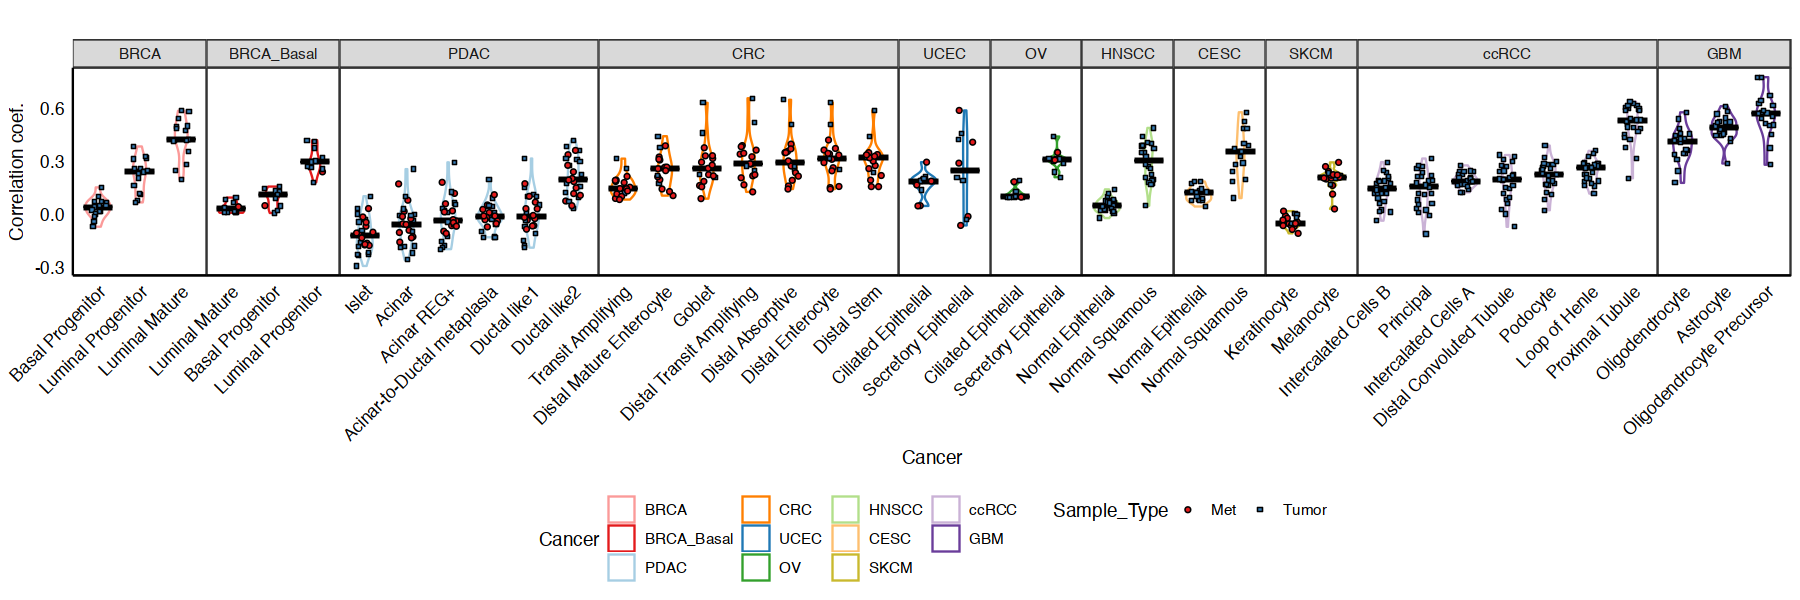

In [17]:
options(repr.plot.width=15, repr.plot.height=5)
p